In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import iqr, norm
import statsmodels.stats.api as sms
import arch 

import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsap 
from statsmodels.tsa.stattools import adfuller

# Recursive OLS residuals
from statsmodels.stats.diagnostic import recursive_olsresiduals
from statsmodels.stats.diagnostic import breaks_cusumolsresid
import chow_test

import arch

import warnings
warnings.filterwarnings("ignore")
np.random.seed(432)

In [31]:
inf1 = pd.read_csv('output/inflation_SeasAdj.csv', delimiter=';')
inf1.index = pd.to_datetime(inf1.date)
inf1 = inf1.drop("date", axis = 1)
inf1.head()

,CPI,target,v_cpi,vol_cpi1,inf_seasAdj,IT_reg,inf_seasAdj_l1,inf_seasAdj_l3,inf_seasAdj_l6,inf_seasAdj_l12,inf_seasAdj_l24
date,,,,,,,,,,,
1991-01-01,22.52,15.0,60.627675,2.675978,9.880211,0.0,8.754878,4.987363,2.492146,-0.745213,-0.745857
1991-02-01,22.44,15.0,57.473684,2.720473,7.549196,0.0,9.880211,5.352473,-0.947648,-2.350165,-0.559120
1991-03-01,22.47,15.0,53.065395,2.648030,4.624009,0.0,7.549196,8.754878,3.725007,-2.689049,0.049400
1991-04-01,22.77,15.0,49.409449,2.520100,3.425398,0.0,4.624009,9.880211,4.987363,-2.915225,1.433347
1991-05-01,23.02,15.0,42.538700,2.392220,-0.405630,0.0,3.425398,7.549196,5.352473,0.279101,2.354251


In [32]:
simdf = inf1.loc['1993-01-01':'2021-12-01']
predf = simdf.loc['1992-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

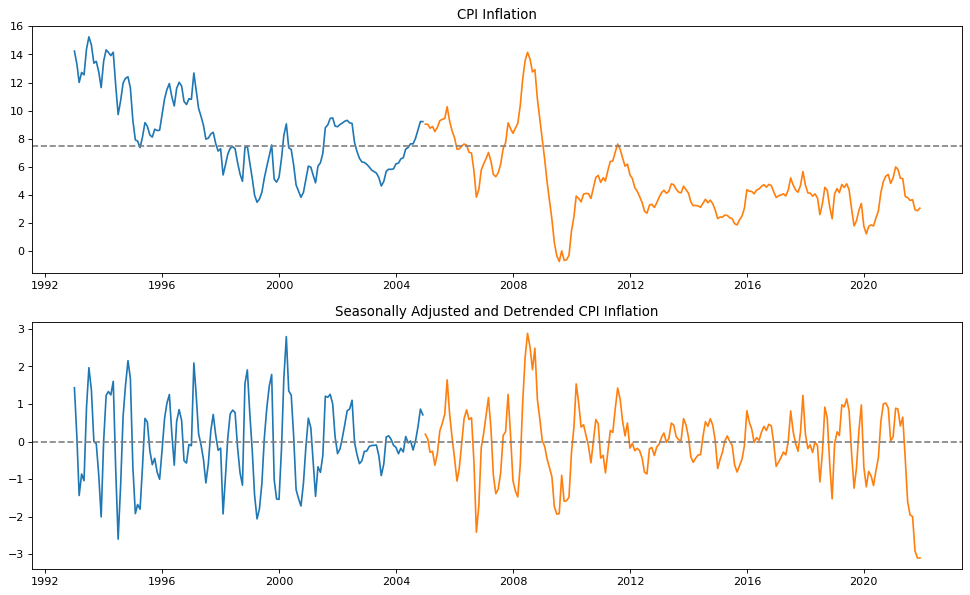

In [33]:
# Ploting the data
fig, axes = plt.subplots(2, 1, figsize=(15,9), dpi= 80)

axes[0].plot(predf['v_cpi'])
axes[0].plot(itdf['v_cpi'])
axes[0].set_title('CPI Inflation')
axes[0].axhline(y=np.mean(inf1['v_cpi']), color='grey', linestyle='--')

axes[1].plot(predf['inf_seasAdj'])
axes[1].plot(itdf['inf_seasAdj'])
axes[1].set_title('Seasonally Adjusted and Detrended CPI Inflation')
axes[1].axhline(y=0, color='grey', linestyle='--')

plt.show()


In [35]:
# GARCH(1,1)
garch = arch.arch_model(simdf['inf_seasAdj'], p=1, q=1, o=0, mean='zero', rescale=False, dist='gaussian', vol='garch')

In [62]:
# garch.fit(disp=False)
res = garch.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:            inf_seasAdj   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -421.268
Distribution:                  Normal   AIC:                           848.536
Method:            Maximum Likelihood   BIC:                           860.093
                                        No. Observations:                  348
Date:                Wed, Jul 06 2022   Df Residuals:                      348
Time:                        12:44:16   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0216  1.523e-02      1.419      0.156 [-8.240e-03,5.145e-02]
alpha[1]       0.2102  6.453e-02      3.258  1.121e-03    [8.378e-02,  0.337]
beta[1]        0.7803  7.327e-02     10.649  1.770e-26      [  0.637,  0.924]
=============================================================================

Covariance estimator: robust
"""

In [63]:
ITVolMean = res.conditional_volatility.loc['2005-01-01':].mean()
PreVolMean = res.conditional_volatility.loc[:'2004-12-01'].mean()

In [64]:
# Test de diferencia de medias std
from scipy import stats
t_check=stats.ttest_ind(res.conditional_volatility.loc['2005-01-01':].values.tolist(), res.conditional_volatility.loc[:'2004-12-01'].values.tolist())
t_check
alpha=0.05
if(t_check[1]<alpha):
    print('pre_mean different from it_mean')
    print(t_check)

pre_mean different from it_mean
Ttest_indResult(statistic=-5.082046713505136, pvalue=6.123588051161115e-07)


Text(2019-06-01 00:00:00, 0.731168930906047, 'IT Mean 0.80')

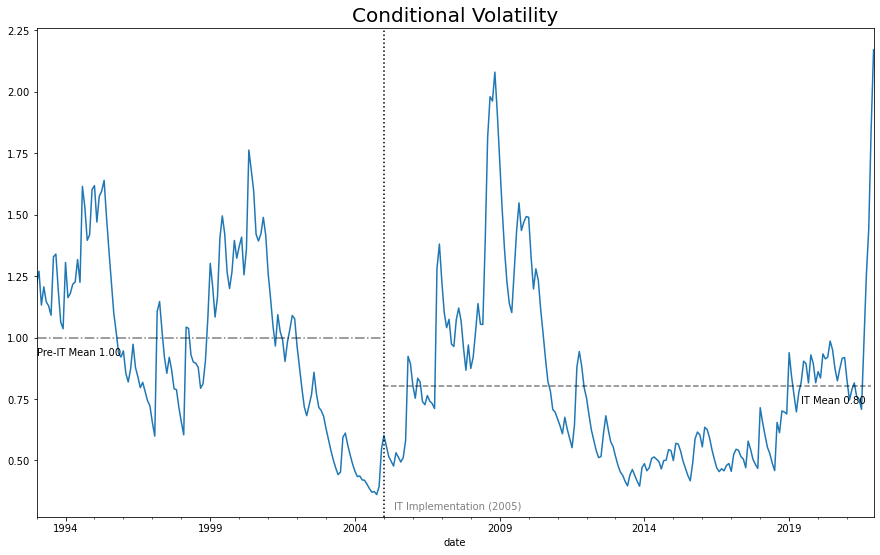

In [65]:
# pd.to_datetime(df_m.index[20])
x0 = (simdf.index.get_loc('1993-01-01'))/len(simdf.index)
x1 = (simdf.index.get_loc('2004-12-01'))/len(simdf.index)
x2 = (simdf.index.get_loc('2005-01-01'))/len(simdf.index)
x3 = (simdf.index.get_loc('2021-12-01'))/len(simdf.index)

res.conditional_volatility.plot(figsize=(15,9))
plt.title('Conditional Volatility', fontsize=20)
plt.axvline(x=pd.to_datetime('2005-01-01'), color='black', linestyle=':')
plt.text(pd.to_datetime('2005-05-01'),0.30, 'IT Implementation (2005)', fontsize=10, alpha=0.5)
plt.axhline(xmin=x0, xmax=x1, y=PreVolMean, color='k', alpha = 0.5, linestyle='-.')
plt.axhline(xmin=x2, xmax=x3, y=ITVolMean, color='k', alpha = 0.5, linestyle='--')

plt.text(pd.to_datetime('1993-01-01'),PreVolMean-0.07, 'Pre-IT Mean {:.2f}'.format(PreVolMean), fontsize=10)
plt.text(pd.to_datetime('2019-06-01'),ITVolMean-0.07, 'IT Mean {:.2f}'.format(ITVolMean), fontsize=10)